In [3]:
# Comme je travail sur colab, j'ai eu besoin d'importer les images sur mon drive. 
# Commande pour accéder à mon drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Vérification du nombre d'image
import os
print(len(os.listdir('/content/drive/MyDrive/image/images2')))

9447


# Import des packages

In [26]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, CSV file I/O (e.g. pd.read_csv)
import os                       # files handling
import re
from PIL import Image
from random import randint, seed
from IPython.display import display
import matplotlib.pyplot as plt
import json
import warnings
import requests
import seaborn as sns
warnings.filterwarnings('ignore')
import cv2
import tensorflow
from tensorflow import keras
from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense, Dropout, Flatten, LeakyReLU # Pour instancier une couche dense
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Import des images  

In [5]:
# Fonction pour charger toutes les images

def load_jpeg_images(path):

    image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.jpeg')]
    images = []
    ids=[]
    for file in image_files:
        ids.append(os.path.splitext(file)[0])
        image = cv2.imread(os.path.join(path, file))
        img = cv2.resize(image, (60, 60))
        images.append(img)

    dataimage = pd.DataFrame({"ids":ids , "img":images})
    datachampi = pd.read_csv('/content/champignons.csv')

    datachampi = datachampi[['label','image_id']]

    dataimage[['ids']] = dataimage[['ids']].astype('int64')

    dataset = pd.merge(dataimage, datachampi, left_on='ids', right_on='image_id',how='left')

    return dataset
    
df=load_jpeg_images("/content/drive/MyDrive/image/images2/")

In [6]:
# Mise en place du jeu de X et Y en numpy pour qu'il puisse être traité dans les réseaux de neuronnes
display(df.head())
X = df['img'].to_numpy()
Y = df['label'].to_numpy()

,ids,img,label,image_id
0,664498,"[[[28, 23, 28], [25, 21, 26], [23, 19, 24], [2...",Laetiporus sulphureus,664498
1,666519,"[[[126, 170, 153], [70, 116, 116], [98, 133, 1...",Coprinus comatus,666519
2,666977,"[[[64, 70, 69], [73, 77, 76], [27, 33, 32], [6...",Laetiporus sulphureus,666977
3,661178,"[[[5, 9, 10], [14, 46, 51], [53, 166, 169], [5...",Laetiporus sulphureus,661178
4,66580,"[[[38, 49, 71], [70, 84, 98], [18, 42, 49], [5...",Amanita phalloides,66580


In [7]:
# Modification de la taille de X pour que tous ces éléments soient pris en compte dans ses dimensions
X = np.stack(X)
print(X.shape)
print(Y.shape)

(9448, 60, 60, 3)
(9448,)


Pour la préparation des données, nous sommes partis de 2 jeux de données. Nous avons du télécharger toutes le images et toutes les informations qui leur correspondait.
Grâce au numéro d'indice, nous avons pu regrouper les images avec leur libéllé.
Nous avons au total 9447 images et une fois le regroupement effectuer seulement 9421 ont été retenu.

# Première visualisation

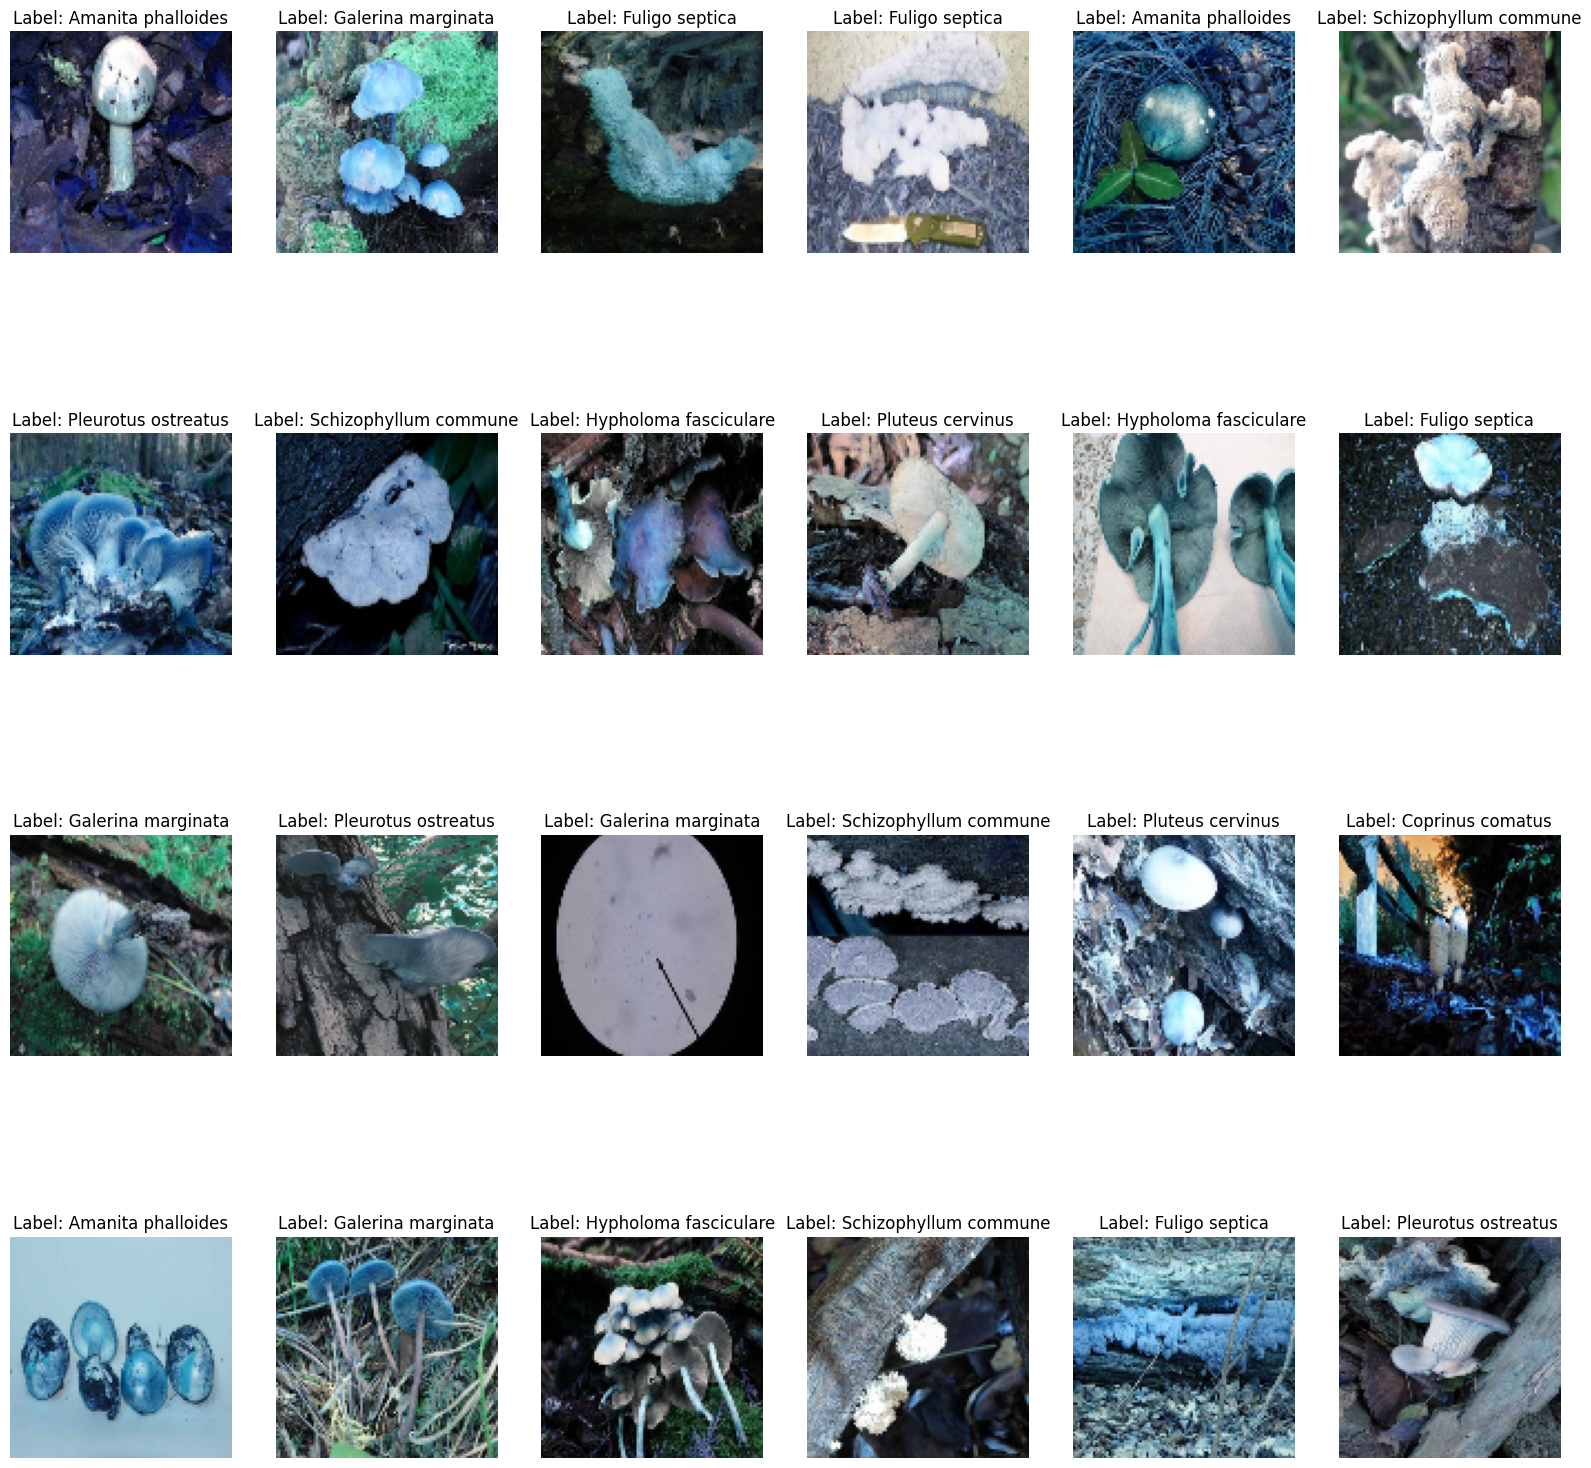

In [ ]:
nb_col = 6
nb_lig = 4
j = 1

plt.figure(figsize=(20,20))

for i in np.random.choice(np.arange(0, len(Y)), size = nb_lig*nb_col):
    # On sélectionne une Image (corrspondant au nombre aléatorie choisi)
    sample0 = np.array(X[i]) 
    # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
    # a 2 lignes et 3 colonnes.
    plt.subplot(nb_lig, nb_col, j)
    j = j + 1
    
    # Suppresion des axes
    plt.axis('off')
    
    plt.imshow(sample0)

    # Modification du titre de la figure
    plt.title('Label: ' + str(Y[i]))


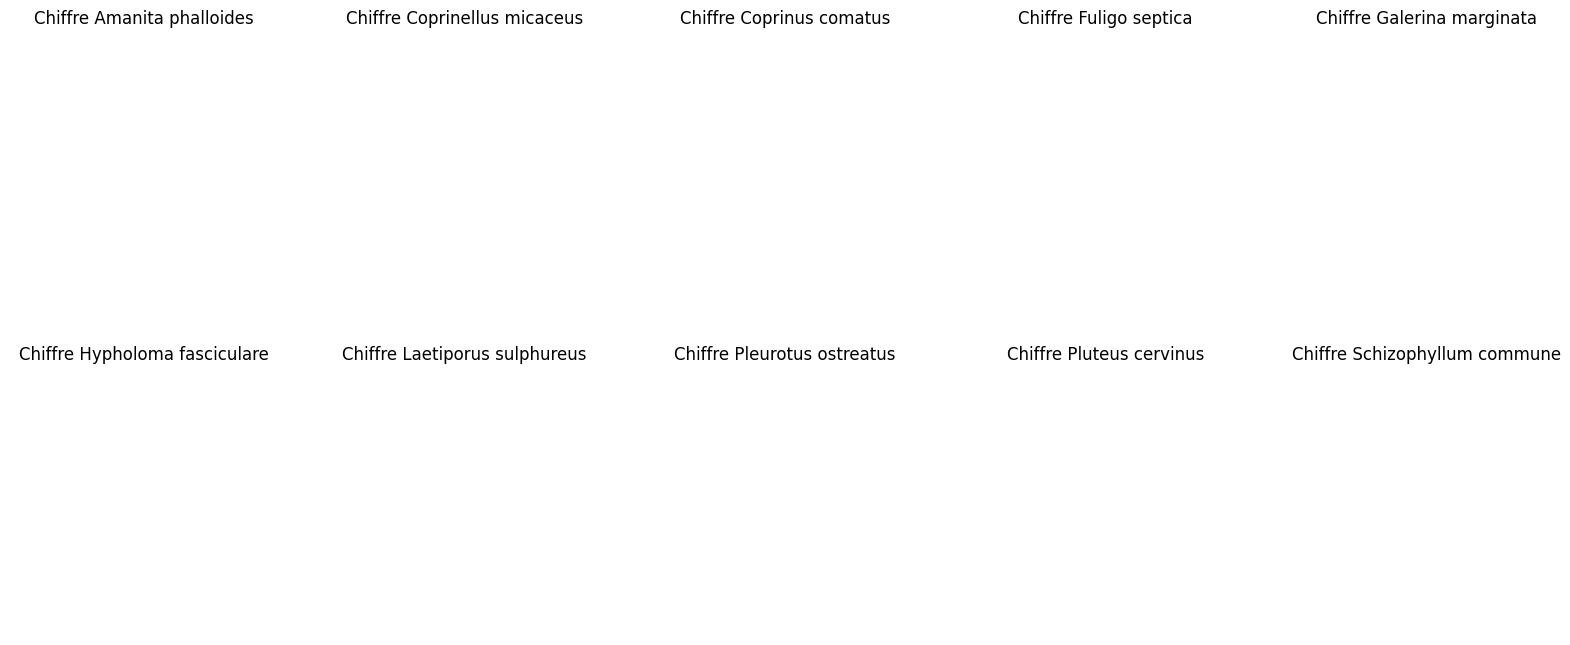

In [ ]:
somme = 0
plt.figure(figsize=(20,8))
for i in np.unique(Y):
  champi_commun = X[Y == i]

  champi_mean = champi_commun.mean(axis=0)

  plt.subplot(2, 5, somme+1)
  plt.imshow(champi_mean)
  plt.axis('off')
  plt.title('Chiffre ' + str(i))
  somme = somme + 1

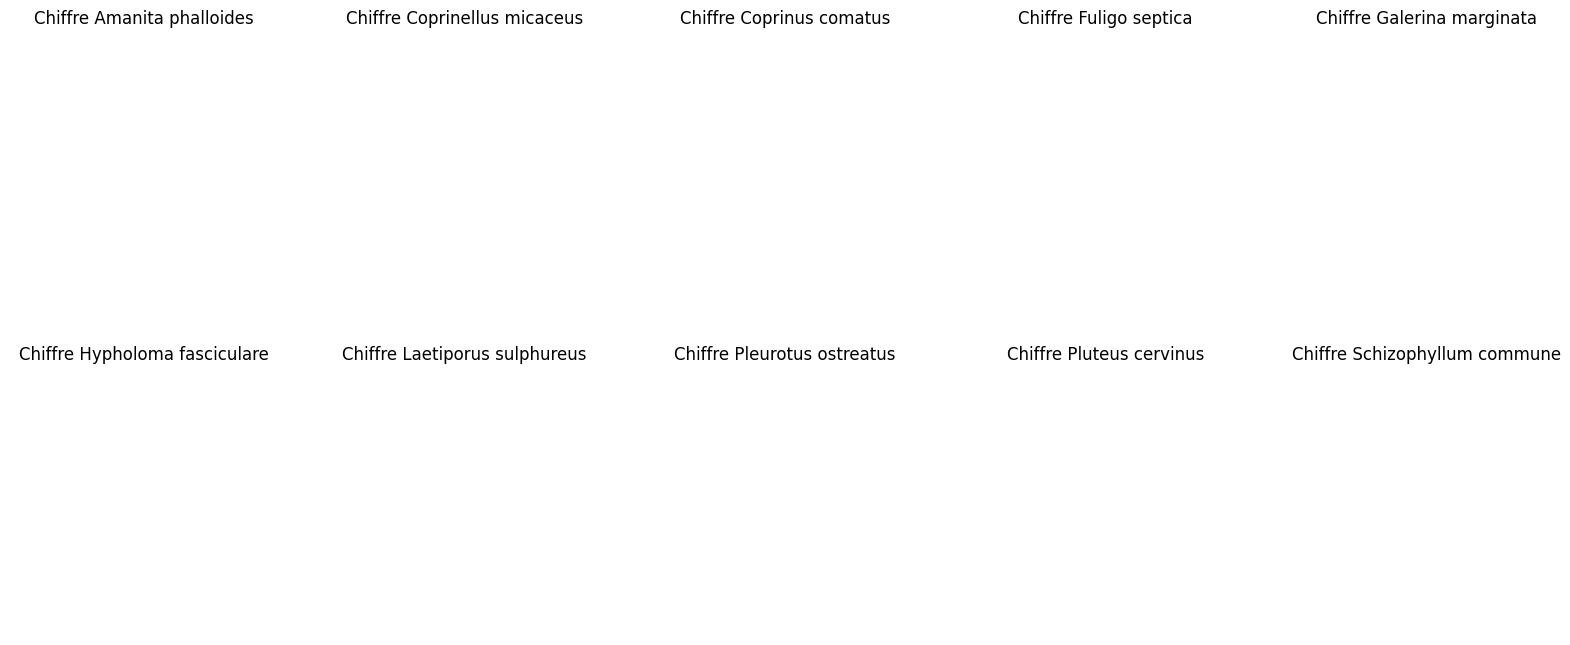

In [ ]:
somme = 0
plt.figure(figsize=(20,8))
for i in np.unique(Y):
  champi_commun = X[Y == i]

  champi_std = champi_commun.std(axis=0)

  plt.subplot(2, 5, somme+1)
  plt.imshow(champi_std)
  plt.axis('off')
  plt.title('Chiffre ' + str(i))
  somme = somme + 1

Dans les deux étapes précédentes, nous faisons la moyenne et l'ecart-types des pixels. Or nous obtenons des images noir et blanche puisque les images ne se ressemblent pas du tout. Elles peuevent etre prise de tous les angles ce qui empeche de les lire correctement.

# Pré possessing

In [ ]:
# One hot encoding
Y = pd.get_dummies(Y)

# Création du jeu d'entrainement et du jeu de test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25)
print('Les dimensions de X_train est de '+str(X_train.shape)+'.')
print('Les dimensions de Y_train est de '+str(Y_train.shape)+'.')
print('Les dimensions de X_test est de '+str(X_test.shape)+'.')
print('Les dimensions de Y_test est de '+str(Y_test.shape)+'.')

# Redimension des jeu de train
X_train1 = X_train.reshape([-1, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]])
X_test1 = X_test.reshape([-1, X_test.shape[1]*X_test.shape[2]*X_train.shape[3]])

X_train1 = X_train1/255
X_test1 = X_test1/255

nb_pixel = X_train1.shape[1]
nb_class = Y_train.shape[1]

print("\n\nLe nombre de pixels est de : ", nb_pixel)
print("Le nombre de classes est de : ", nb_class)

Les dimensions de X_train est de (7086, 100, 100, 3).
Les dimensions de Y_train est de (7086, 10).
Les dimensions de X_test est de (2362, 100, 100, 3).
Les dimensions de Y_test est de (2362, 10).


Le nombre de pixels est de :  30000
Le nombre de classes est de :  10


Pour pouvoir commencer à construire un réseau de neurones. Il faut remplir quelques conditions.
- Avoir les données dans de bonnes dimensions
- Pour un model sequentiel il faut avoir les images en 1 dimensions
- Vérifier que les données de sorties soit labellisé correctement

# Deep learning

In [ ]:
# Fonction qui permet de présenter la prédiction du jeu de test
# Elle permet également de visualiser les résultats de l'entrainement
def analyze_model(model, X_test, y_test, train_hist, epochs_nb = 20):
    score = model.evaluate(X_test, y_test)  
    erreur = 100*(1-score[1])
    print('Perte sur le set de test: %4.3f '%score[0])
    print('Erreur sur le set de test:  %4.2f %%'% erreur)

    train_acc = train_hist.history['accuracy']
    val_acc = train_hist.history['val_accuracy']
    
    epo = epochs_nb + 1
    
    plt.figure(figsize = (10,7))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1, epo,1), train_acc, color = 'orange', label= 'accuracy')
    plt.plot(np.arange(1, epo,1), val_acc, color = 'blue', label= 'accuracy validation')
    plt.legend()
    plt.show();

## Premier réseaux de neurones

In [ ]:
# Premier réseau de neuronnes model sequentiel
model = Sequential()
# Utilisation de 4 couches avec les activations tanh, relu, leakyrelu et softmax

first_layer = Dense(units = 150, 
                       input_dim = nb_pixel, 
                       activation = 'tanh', 
                       kernel_initializer = 'normal')

second_layer = Dense(units = 150,
                         activation = 'relu',
                         kernel_initializer = 'normal')

third_layer = Dense(units = 150,
                         activation = LeakyReLU(alpha=0.1),
                         kernel_initializer = 'normal')

four_layer = Dense(units = nb_class, 
                        activation = 'softmax', 
                        kernel_initializer = 'normal')

model.add(first_layer)
model.add(second_layer)
model.add(third_layer)
model.add(four_layer)

# Utilisation d'une dessente de gradient
model.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               4500150   
                                                                 
 dense_1 (Dense)             (None, 150)               22650     
                                                                 
 dense_2 (Dense)             (None, 150)               22650     
                                                                 
 dense_3 (Dense)             (None, 10)                1510      
                                                                 
Total params: 4,546,960
Trainable params: 4,546,960
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
training_history = model.fit(X_train1, Y_train, 
                                    batch_size=400, 
                                    epochs=100, 
                                    validation_split=0.2,
                                    verbose=1,
                                    initial_epoch=0,
                                    workers=-1)

Epoch 1/100
15/15 [==============================] - 8s 482ms/step - loss: 2.3143 - accuracy: 0.0963 - val_loss: 2.3083 - val_accuracy: 0.0860
Epoch 2/100
15/15 [==============================] - 4s 285ms/step - loss: 2.3067 - accuracy: 0.0962 - val_loss: 2.3009 - val_accuracy: 0.0959
Epoch 3/100
15/15 [==============================] - 3s 204ms/step - loss: 2.3009 - accuracy: 0.1106 - val_loss: 2.2953 - val_accuracy: 0.1142
Epoch 4/100
15/15 [==============================] - 3s 204ms/step - loss: 2.2964 - accuracy: 0.1274 - val_loss: 2.2907 - val_accuracy: 0.1354
Epoch 5/100
15/15 [==============================] - 4s 264ms/step - loss: 2.2927 - accuracy: 0.1388 - val_loss: 2.2867 - val_accuracy: 0.1495
Epoch 6/100
15/15 [==============================] - 4s 297ms/step - loss: 2.2894 - accuracy: 0.1434 - val_loss: 2.2830 - val_accuracy: 0.1573
Epoch 7/100
15/15 [==============================] - 3s 224ms/step - loss: 2.2865 - accuracy: 0.1438 - val_loss: 2.2802 - val_accuracy: 0.1587

74/74 [==============================] - 1s 15ms/step - loss: 2.0836 - accuracy: 0.2553
Perte sur le set de test: 2.084 
Erreur sur le set de test:  74.47 %


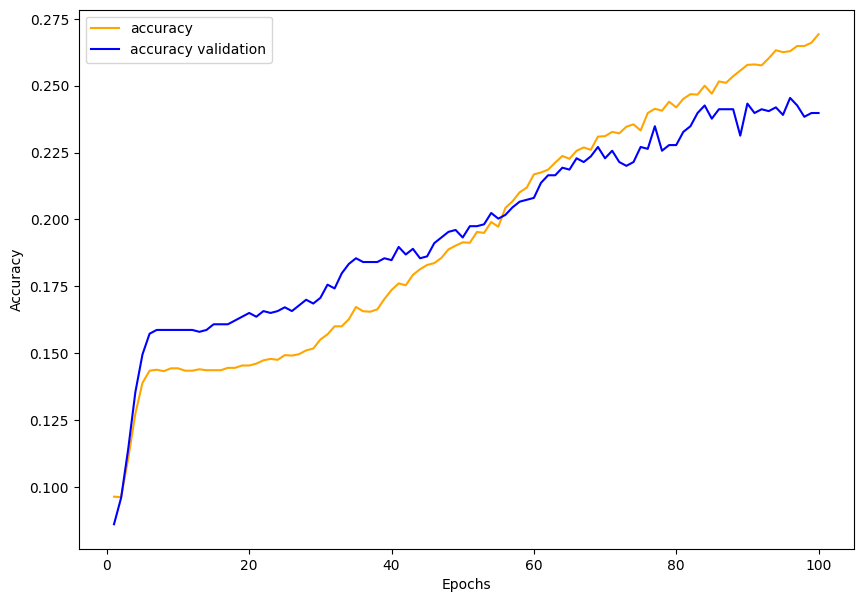

In [ ]:
analyze_model(model,X_test1,Y_test,training_history,100)

## Deuxième réseau de neuronnes - Ajout de couches Dropout

In [ ]:
# Deuxième réseau de neuronnes model sequentiel
# Utilisation de 4 couches avec les activations tanh, relu, leakyrelu et softmax en utilisant des couches DropOut
model2 = Sequential()

first_layer2 = Dense(units = 200, 
                       input_dim = nb_pixel, 
                       activation = 'tanh', 
                       kernel_initializer = 'normal')

five_layer2 = Dropout(rate = 0.5)

six_layer2 = Dense(units = 200,
                         activation = 'relu',
                         kernel_initializer = 'normal')

seven_layer2 = Dropout(rate = 0.5)

eigt_layer2 = Dense(units = 200,
                         activation = LeakyReLU(alpha=0.2),
                         kernel_initializer = 'normal')

nine_layer2 = Dropout(rate = 0.5)

ten_layer2 = Dense(units = nb_class, 
                        activation = 'softmax', 
                        kernel_initializer = 'normal')

model2.add(first_layer2)
# model2.add(second_layer2)
# model2.add(third_layer2)
# model2.add(four_layer2)
model2.add(five_layer2)
model2.add(six_layer2)
model2.add(seven_layer2)
model2.add(eigt_layer2)
model2.add(nine_layer2)
model2.add(ten_layer2)

model2.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               6000200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 10)               

None

In [ ]:
training_history2 = model2.fit(X_train1, Y_train, 
                                    batch_size=40, 
                                    epochs=100, 
                                    validation_split=0.3,
                                    verbose=1,
                                    initial_epoch=0,
                                    workers=-1)

Epoch 1/150
124/124 [==============================] - 10s 55ms/step - loss: 2.3571 - accuracy: 0.1161 - val_loss: 2.2774 - val_accuracy: 0.1444
Epoch 2/150
124/124 [==============================] - 8s 67ms/step - loss: 2.3139 - accuracy: 0.1216 - val_loss: 2.2742 - val_accuracy: 0.1543
Epoch 3/150
124/124 [==============================] - 6s 48ms/step - loss: 2.3016 - accuracy: 0.1335 - val_loss: 2.2699 - val_accuracy: 0.1613
Epoch 4/150
124/124 [==============================] - 8s 65ms/step - loss: 2.2908 - accuracy: 0.1393 - val_loss: 2.2652 - val_accuracy: 0.1740
Epoch 5/150
124/124 [==============================] - 6s 45ms/step - loss: 2.2878 - accuracy: 0.1375 - val_loss: 2.2633 - val_accuracy: 0.1726
Epoch 6/150
124/124 [==============================] - 7s 59ms/step - loss: 2.2718 - accuracy: 0.1474 - val_loss: 2.2564 - val_accuracy: 0.1717
Epoch 7/150
124/124 [==============================] - 6s 52ms/step - loss: 2.2715 - accuracy: 0.1498 - val_loss: 2.2520 - val_accuracy

74/74 [==============================] - 1s 14ms/step - loss: 2.2287 - accuracy: 0.2731
Perte sur le set de test: 2.229 
Erreur sur le set de test:  72.69 %


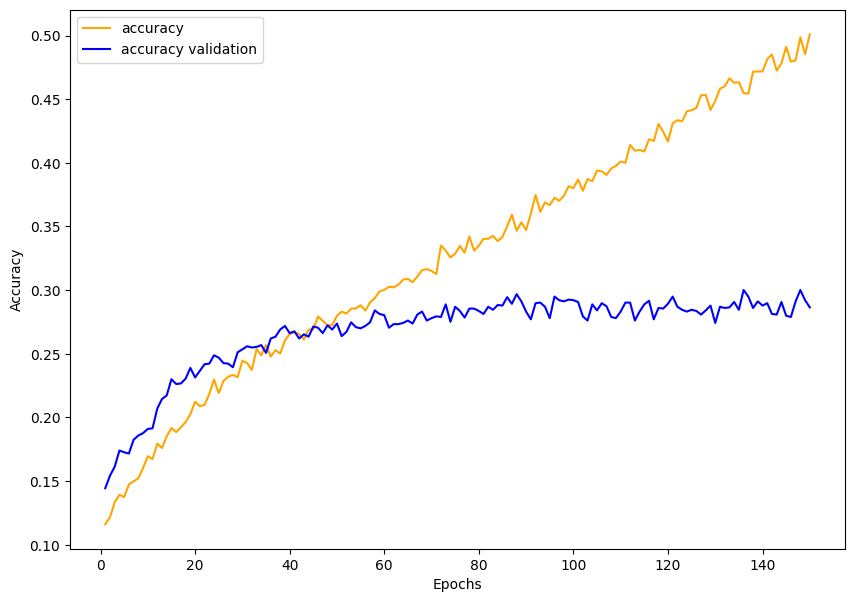

In [ ]:
analyze_model(model2,X_test1,Y_test,training_history2,150)

## Troisième réseau de neurone - Réseau de neurones à couches convolutionnelles

In [8]:
# Redéfinition des données

# One hot encoding
Y = pd.get_dummies(Y)

# Création du jeu d'entrainement et du jeu de test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25)
print('Les dimensions de X_train est de '+str(X_train.shape)+'.')
print('Les dimensions de Y_train est de '+str(Y_train.shape)+'.')
print('Les dimensions de X_test est de '+str(X_test.shape)+'.')
print('Les dimensions de Y_test est de '+str(Y_test.shape)+'.')

# Normaliser
X_train2 = X_train/255
X_test2 = X_test/255

nb_class = Y_test.shape[1]
print('Le nombre de classe du jeu de donnée est ',str(nb_class))

Les dimensions de X_train est de (7086, 60, 60, 3).
Les dimensions de Y_train est de (7086, 10).
Les dimensions de X_test est de (2362, 60, 60, 3).
Les dimensions de Y_test est de (2362, 10).
Le nombre de classe du jeu de donnée est  10


In [ ]:
# CNN
# Utilisation d'une couche de convolution
# utilisant des couches DropOut


model_CNN = Sequential()
first_layer_CNN = Conv2D(
    filters = 16, 
    kernel_size = (5, 5),
    padding = 'valid',
    input_shape = (100, 100, 3),
    activation = 'relu'
)
second_layer_CNN = MaxPooling2D(pool_size = (5, 5))
third_layer_CNN = Dropout(rate = 0.7)
fourth_layer_CNN = Flatten()
fifth_layer_CNN = Dense(units = 100, activation = 'relu')
six_layer_CNN = Dropout(rate = 0.7)
seven_layer_CNN = Dense(units = 100, activation = LeakyReLU(alpha=0.2))
eigt_layer_CNN = Dropout(rate = 0.7)
last_layer_CNN = Dense(units = nb_class, activation = 'softmax')

model_CNN.add(first_layer_CNN)
model_CNN.add(second_layer_CNN)
model_CNN.add(third_layer_CNN)
model_CNN.add(fourth_layer_CNN)
model_CNN.add(fifth_layer_CNN)
model_CNN.add(six_layer_CNN)
model_CNN.add(last_layer_CNN)


model_CNN.compile(optimizer = keras.optimizers.SGD(),
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])

display(model_CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 19, 19, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 5776)              0         
                                                                 
 dense_3 (Dense)             (None, 100)               577700    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                      

None

In [ ]:
training_history3 = model_CNN.fit(X_train2, Y_train,  
                                  batch_size = 50, 
                                  epochs = 30,
                                  validation_split=0.3, 
                                  verbose=1)

Epoch 1/30
100/100 [==============================] - 12s 22ms/step - loss: 2.3172 - accuracy: 0.1175 - val_loss: 2.2908 - val_accuracy: 0.1500
Epoch 2/30
100/100 [==============================] - 2s 16ms/step - loss: 2.2937 - accuracy: 0.1222 - val_loss: 2.2854 - val_accuracy: 0.1632
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 2.2889 - accuracy: 0.1440 - val_loss: 2.2759 - val_accuracy: 0.1839
Epoch 4/30
100/100 [==============================] - 1s 14ms/step - loss: 2.2782 - accuracy: 0.1552 - val_loss: 2.2645 - val_accuracy: 0.1834
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 2.2680 - accuracy: 0.1637 - val_loss: 2.2428 - val_accuracy: 0.2004
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2490 - accuracy: 0.1700 - val_loss: 2.2283 - val_accuracy: 0.2041
Epoch 7/30
100/100 [==============================] - 1s 12ms/step - loss: 2.2356 - accuracy: 0.1734 - val_loss: 2.2052 - val_accuracy: 0.213

74/74 [==============================] - 14s 189ms/step - loss: 1.6398 - accuracy: 0.4285
Perte sur le set de test: 1.640 
Erreur sur le set de test:  57.15 %


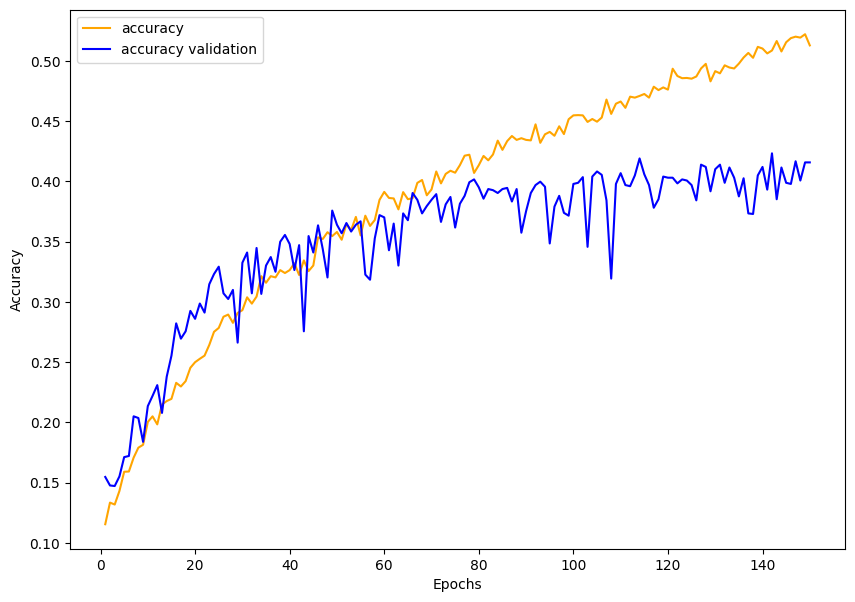

In [ ]:
analyze_model(model_CNN,X_test2,Y_test,training_history3,150)

## Deuxième CNN - Optimisation des paramètres

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

In [28]:
# Définir la fonction qui construit votre modèle
def build_model(filters, kernel_size, padding, activation, dropout_rate, dense_units, leaky_alpha):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, 
                     input_shape=(60, 60, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=100, activation=LeakyReLU(alpha=leaky_alpha)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=nb_class, activation='softmax'))
    model.compile(optimizer=keras.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [31]:
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=0)

# Définir les hyperparamètres à tester
filters = [16, 32, 64]
kernel_size = [(3, 3), (5, 5), (7, 7)]
padding = ['valid', 'same']
activation = ['relu', 'sigmoid']
dropout_rate = [0.5, 0.7]
dense_units = [50, 100, 200]
leaky_alpha = [0.1, 0.2, 0.3]

# Créer un dictionnaire des hyperparamètres
param_grid = dict(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation,
                  dropout_rate=dropout_rate, dense_units=dense_units, leaky_alpha=leaky_alpha)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_test2, Y_test)

# Afficher les meilleurs hyperparamètres trouvés
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Afficher les résultats pour toutes les combinaisons d'hyperparamètres testées
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Visualisation des models

In [ ]:
proba_class_test = model_CNN.predict(X_test)
predict_class_test = proba_class_test.argmax(axis=1)
Y_test = Y_test.to_numpy()
Y_test_class = Y_test.argmax(axis=1)


print(metrics.classification_report(Y_test_class, predict_class_test))

74/74 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.33      0.03      0.06       209
           1       0.14      0.21      0.17       193
           2       0.92      0.04      0.08       270
           3       0.39      0.39      0.39       196
           4       0.45      0.08      0.14       261
           5       0.21      0.65      0.32       294
           6       0.30      0.52      0.38       216
           7       0.53      0.03      0.06       329
           8       0.44      0.02      0.04       187
           9       0.24      0.60      0.35       201

    accuracy                           0.25      2356
   macro avg       0.40      0.26      0.20      2356
weighted avg       0.41      0.25      0.19      2356



In [ ]:
import itertools

def print_nice_conf_matrix(y, cnf_matrix):
    '''
    Fonction dediee a rendre une jolie matrice de confusion a partir de :
        - y : un array contenant les classes pour la classification. Sert uniquement a compter le nombre de classes.
        - cnf_matrix : la matrice de confusion qui nous interesse.
    '''
    classes = range(0,(len(np.unique(y))))
    
    plt.figure()
    
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
    
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

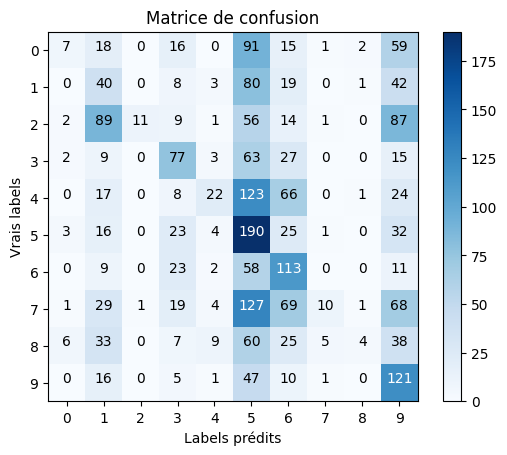

In [ ]:
conf_matrix1 = confusion_matrix(Y_test_class, predict_class_test)

print_nice_conf_matrix(Y_test_class, conf_matrix1)

In [ ]:
# Essaie de mettre en place la grad cam
import tensorflow as tf
import keras.backend as K
from keras.preprocessing import image

class_index = 0

# Charger l'image à visualiser
img = Image.open('/content/drive/MyDrive/image/images/650506.jpg')
img = img.resize((100, 100))

x = np.array(img) / 255.0
x = x.reshape([1,x.shape[0],x.shape[1],x.shape[2]])
print(x.shape)

# Obtenir la sortie de la dernière couche convolutive
last_conv_layer = model_CNN.layers[0]
# Obtenir les activations de la dernière couche convolutive pour l'image donnée
activations = last_conv_layer(x)
print(activations.shape)
# Calculer les gradients pour la classe prédite
class_index = 0  # Remplacer par l'indice de la classe souhaitée
with tf.GradientTape() as tape:
    tape.watch(activations)
    preds = model_CNN(x)
    class_output = preds[:, class_index]
    print(class_output.shape)
grads = tape.gradient(class_output, activations)
print(grads)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiplier chaque canal d'activation par son gradient moyen pondéré
for i in range(pooled_grads.shape[-1]):
    activations[:, :, :, i] *= pooled_grads[i]

# Calculer la carte de chaleur Grad-CAM en faisant la moyenne des activations pondérées
heatmap = np.mean(activations, axis=-1)[0, :, :, :]
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(1, 100, 100, 3)
(1, 96, 96, 32)
(1,)
None


ValueError: ignored